In [1]:
# import uproot
import awkward as ak
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import os
import glob
import pickle as pkl


CRT_Wall_Dict = {
       "South": 1,
       "North": 2,
       "West": 3,
       "East": 4,
       "Bottom": 0,
       "Top Low": 5,
       "Top High": 6
       }

CRT_Wall_Arr = ["Bottom", "South", "North", "West", "East", "Top Low", "Top High"]

In [2]:
def list_matching_files(folder_path, pattern):
    search_pattern = os.path.join(folder_path, pattern)
    files = glob.glob(search_pattern)
    return [f for f in files if os.path.isfile(f)]

def plot_flag_deadtime(trig_time, flag_dict, title=None, bins=100, time_range = (-1.55,-1.5)):
    fig = go.Figure()

    for flag, flag_arr in flag_dict.items():
        plt.hist(trig_time, weights=flag_arr, histtype='step', bins=bins, range=time_range, label=rf'Flag {flag}')
    
    plt.title(title)
    plt.xlabel('FEB TS0 - TDC ETRIG [ms]')
    plt.ylabel('Flag counts')
    plt.yscale('log')
    plt.legend()
    plt.show()

def plot_sp_time(ts0, wall_tag, wall=None, title=None, bins=100, time_range = (-5,5), log_scale=False, wall_names=CRT_Wall_Arr):

    if wall is not None:
        print('wall')
        if type(wall) in (list, np.ndarray):
            print('arr')
            for wall_number in wall:
                plt.hist(ts0[wall_tag==wall_number]+1, histtype='step', bins=bins, range=time_range, label=wall_names[wall_number])
        elif type(wall) == int:
            print('int')
            plt.hist(ts0[wall_tag==wall]+1, histtype='step', bins=bins, range=time_range, label=wall_names[wall])
        else:
            print("Invalid wall type, plotting all walls")
            plt.hist(ts0+1, histtype='step', bins=bins, range=time_range)
        print('plotted')
    else:
        plt.hist(ts0+1, histtype='step', bins=bins, range=time_range)


    plt.title(title)
    plt.xlabel(rf'CRT Space Point Time [$\mu s$]')
    plt.ylabel('Wall counts')
    if log_scale: 
        plt.yscale('log')
    plt.legend(title='Bin width = {:.3}μs'.format((time_range[1]-time_range[0])/bins))
    plt.show()
def plot_sp_coord_ratio(ts0, x, y, z, wall, run, plot_wall=1, interval_in = (-0.1, 1.7), interval_out = (-250, 250), offset=1, check_interval=False, bins=10, save=False):
    
    min_in, max_in = interval_in
    min_out, max_out = interval_out

    interval_in_window = (ts0 + offset > min_in) & (ts0 + offset < max_in) 
    interval_out_window = ((ts0 + offset < min_in) & (ts0 + offset > min_out)) | ((ts0 + offset > max_in) & (ts0 + offset < max_out))

    x_in = x[interval_in_window]
    y_in = y[interval_in_window]
    z_in = z[interval_in_window]

    wall_in = wall[interval_in_window]

    x_out = x[interval_out_window]
    y_out = y[interval_out_window]
    z_out = z[interval_out_window]

    wall_out = wall[interval_out_window]


    if check_interval:
        # Checking that we're splitting as we expect!
        # Slight overlap is due to binning
        time_range = (-5,5)
        bins_check = 50
        ts0_in = ts0[interval_in_window]
        ts0_out = ts0[interval_out_window]
        plt.hist(ts0_in + offset, histtype='step', bins=bins_check, range=time_range, label='In Window')
        plt.hist(ts0_out + offset, histtype='step', bins=bins_check, range=time_range, label='Out Window')
        plt.legend(title='Bin width = {:.3}μs'.format((time_range[1]-time_range[0])/bins_check))
        plt.xlabel('CRT Space Point Time [μs]')
        plt.ylabel('Counts')
        plt.xlim(-5,5)
        plt.show()

    # North/South walls
    if plot_wall == 1 or plot_wall == 2:
        print('north/south')
        x_axis_in = x_in[wall_in == plot_wall]
        y_axis_in = y_in[wall_in == plot_wall]
        x_axis_out = x_out[wall_out == plot_wall]
        y_axis_out = y_out[wall_out == plot_wall]
        x_label = 'X [cm]'
        y_label = 'Y [cm]'

    # Bottom/top walls
    if plot_wall == 0 or plot_wall == 5 or plot_wall == 6:
        print('bottom/top')
        x_axis_in = z_in[wall_in == plot_wall]
        y_axis_in = x_in[wall_in == plot_wall]
        x_axis_out = z_out[wall_out == plot_wall]
        y_axis_out = x_out[wall_out == plot_wall]
        x_label = 'Z [cm]'
        y_label = 'X [cm]'

    # East/West walls
    if plot_wall == 3 or plot_wall == 4:
        print('east/west')
        x_axis_in = z_in[wall_in == plot_wall]
        y_axis_in = y_in[wall_in == plot_wall]
        x_axis_out = z_out[wall_out == plot_wall]
        y_axis_out = y_out[wall_out == plot_wall]
        x_label = 'Z [cm]'
        y_label = 'Y [cm]'
    
    hist_out, xedges, yedges = np.histogram2d(x_axis_out, y_axis_out, bins=bins)
    exposure_out = max_out - min_out - (max_in - min_in)
    hist_out = hist_out/exposure_out

    hist_in, xedges, yedges = np.histogram2d(x_axis_in, y_axis_in, bins=(xedges, yedges))
    exposure_in = max_in - min_in
    hist_in = hist_in/exposure_in
    
    ratio_hist = hist_in/hist_out

    fig, ax = plt.subplots(1,3, figsize=(15,5))
    fig.suptitle(f'{CRT_Wall_Arr[plot_wall]} CRT Space Point Distribution (scaled by exposure time) - Run {run}')
    im1 = ax[0].imshow(hist_in.T, extent=[xedges[0], xedges[-1],yedges[0], yedges[-1]], origin='lower', cmap='viridis')
    ax[0].set_title('In-Window ({} — {} μs)'.format(min_in, max_in))
    ax[0].set_xlabel(x_label)  
    ax[0].set_ylabel(y_label)

    im2 = ax[1].imshow(hist_out.T, extent=[xedges[0], xedges[-1],yedges[0], yedges[-1]], origin='lower', cmap='viridis')
    ax[1].set_title('Out-of-Window ({} —  {} μs)'.format(min_out, max_out))
    ax[1].set_xlabel(x_label)
    ax[1].set_ylabel(y_label)

    im3 = ax[2].imshow(ratio_hist.T, extent=[xedges[0], xedges[-1],yedges[0], yedges[-1]], origin='lower', cmap='viridis')
    ax[2].set_title('In/Out Ratio')
    ax[2].set_xlabel(x_label)
    ax[2].set_ylabel(y_label)

    fig.colorbar(im1, ax=ax[0])
    fig.colorbar(im2, ax=ax[1])
    fig.colorbar(im3, ax=ax[2])
    if save:
        # fig.save(rf'./figures/space_point_{CRT_Wall_Arr[plot_wall]}.png')
        plt.savefig(rf'./figures/space_point_{CRT_Wall_Arr[plot_wall]}.png')
    plt.show()



In [12]:
# Summer runs
list_of_runs = [13688, 13689, 13690, 13693, 13758]
batch_size = 3
filename = "crtana_data_*"

# December runs
list_of_runs = [17985, 17987]
batch_size = 5
filename = "crt_ana_*" 

# path = "/exp/sbnd/data/users/jbateman/workdir/crt/run/"
path = "/pnfs/sbnd/persistent/users/jbateman/crt/run/"
n_batches = []



for run in list_of_runs:

    folder_path = path + "0" + str(run) + "/"
    matching_files = list_matching_files(folder_path,filename)
    n_batches.append(int(np.ceil(len(matching_files)/batch_size)))

In [13]:
n_batches

[36, 59]

In [14]:
path = "/exp/sbnd/data/users/jbateman/workdir/crt/run/"
filename_deadtime = 'flag_t0_etrig_' # 'flag_t0_etrig.pkl'
filename_sp = 'sp_timing_'

arr_flag_t0_etrig = np.empty((0, 3))
arr_sp_timing = np.empty((0, 5))

for i, run in enumerate(list_of_runs):
    for batch in range(n_batches[i]):
        batch_deadtime = filename_deadtime + str(batch) + '.pkl'
        batch_sp = filename_sp + str(batch) + '.pkl'
        
        with open(path + "0" + str(run) + "/" + batch_deadtime, 'rb') as f:
            data_deadtime = pkl.load(f)
            arr_flag_t0_etrig = np.vstack([arr_flag_t0_etrig, np.column_stack((data_deadtime['t0_etrig'], data_deadtime['flag_11'], data_deadtime['flag_3']))])
        
        with open(path + "0" + str(run) + "/" + batch_sp, 'rb') as f:
            data_sp = pkl.load(f)
            arr_sp_timing = np.vstack([arr_sp_timing, np.column_stack((data_sp['relative_ts0'], data_sp['wall_tag'], data_sp['filter_spx'], data_sp['filter_spy'], data_sp['filter_spz']))])

ts0_etrig = arr_flag_t0_etrig[:, 0]
flag_11 = arr_flag_t0_etrig[:, 1]
flag_3 = arr_flag_t0_etrig[:, 2]

ts0_rwm = arr_sp_timing[:, 0]
wall = arr_sp_timing[:, 1]
spx = arr_sp_timing[:, 2]
spy = arr_sp_timing[:, 3]
spz = arr_sp_timing[:, 4]

: 

In [22]:
ts0_etrig = arr_flag_t0_etrig[:, 0]
flag_11 = arr_flag_t0_etrig[:, 1]
flag_3 = arr_flag_t0_etrig[:, 2]

ts0_rwm = arr_sp_timing[:, 0]
wall = arr_sp_timing[:, 1]
spx = arr_sp_timing[:, 2]
spy = arr_sp_timing[:, 3]
spz = arr_sp_timing[:, 4]

## Dead time

/tmp/ipykernel_2571946/88249256.py:15: UserWarning:

Data has no positive values, and therefore cannot be log-scaled.



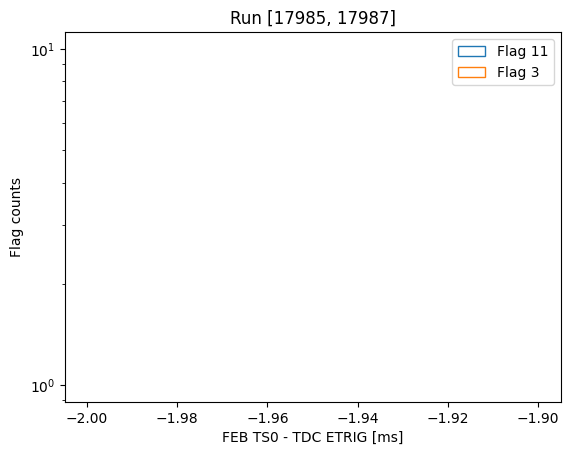

In [14]:
time_range = (-2,-1.9)
plot_flag_deadtime(ts0_etrig, {11: flag_11, 3: flag_3}, title=f"Run {list_of_runs}", time_range=time_range)


## Top hat

wall
int
plotted


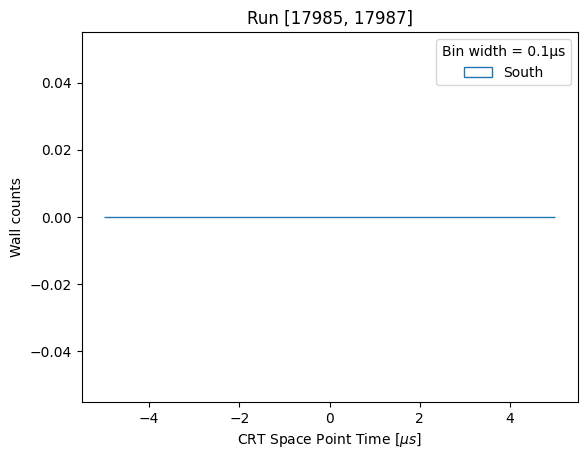

wall
int
plotted


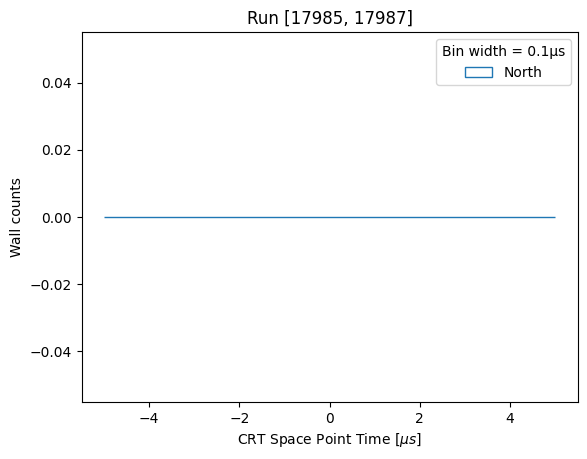

In [15]:
plot_sp_time(ts0_rwm, wall, wall=1, title=f"Run {list_of_runs}", bins=100)
plot_sp_time(ts0_rwm, wall, wall=2, title=f"Run {list_of_runs}", bins=100)

wall
arr
plotted


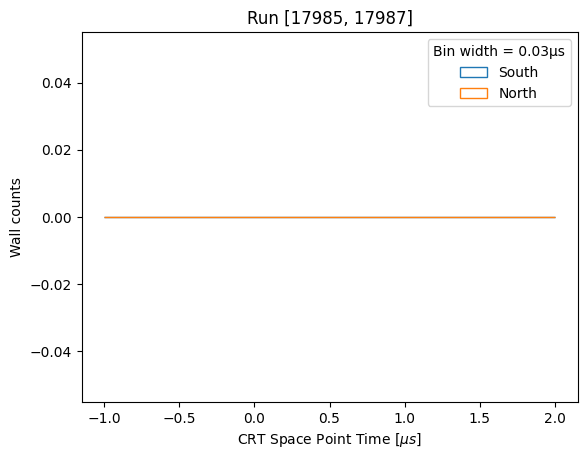

In [16]:
plot_sp_time(ts0_rwm, wall, wall=[1,2], title=f"Run {list_of_runs}", time_range=(-1,2), bins=100)

## Space-point distribution

1
north/south


/tmp/ipykernel_2571946/88249256.py:119: RuntimeWarning:

invalid value encountered in divide



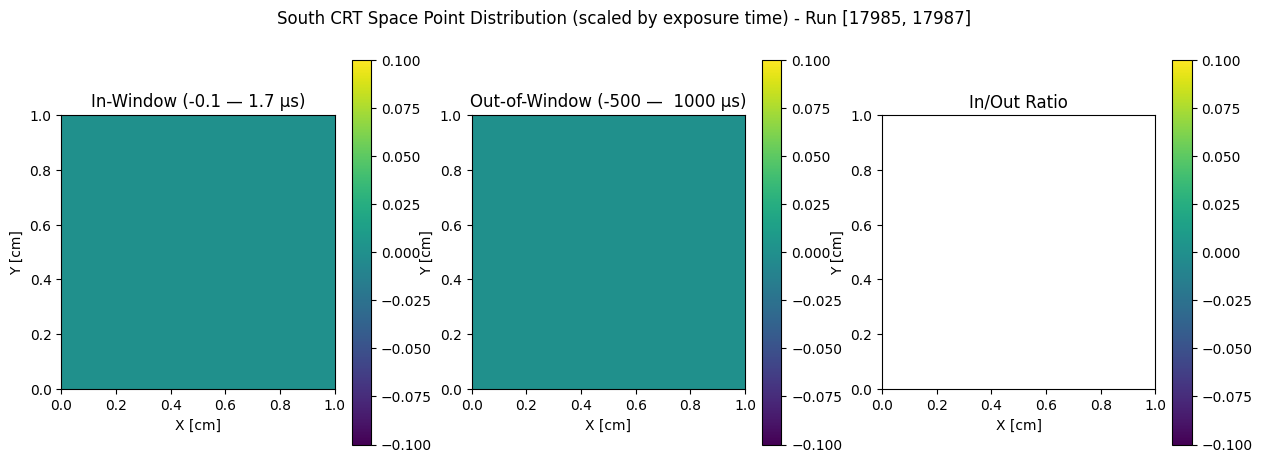

2
north/south


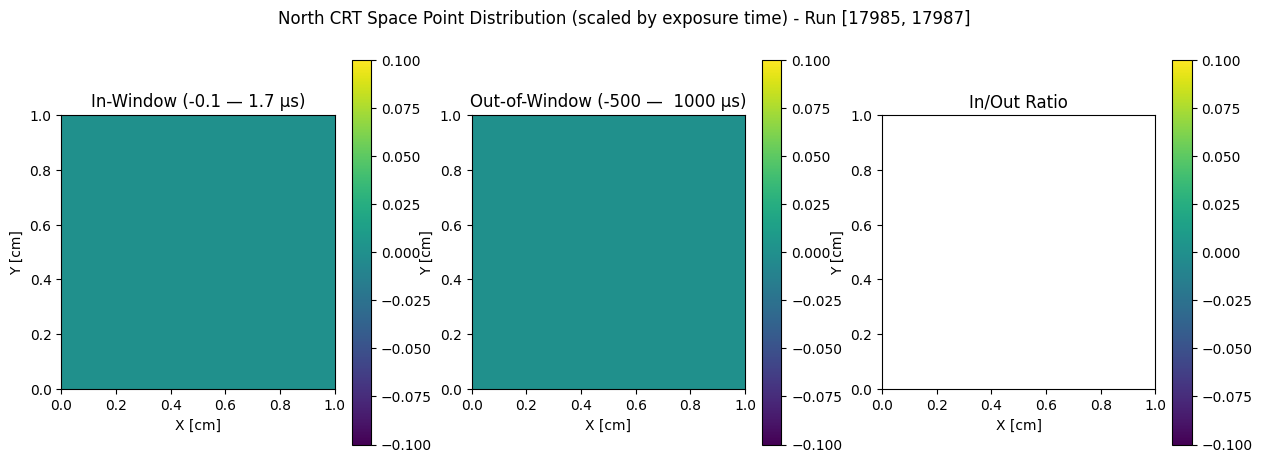

3
east/west


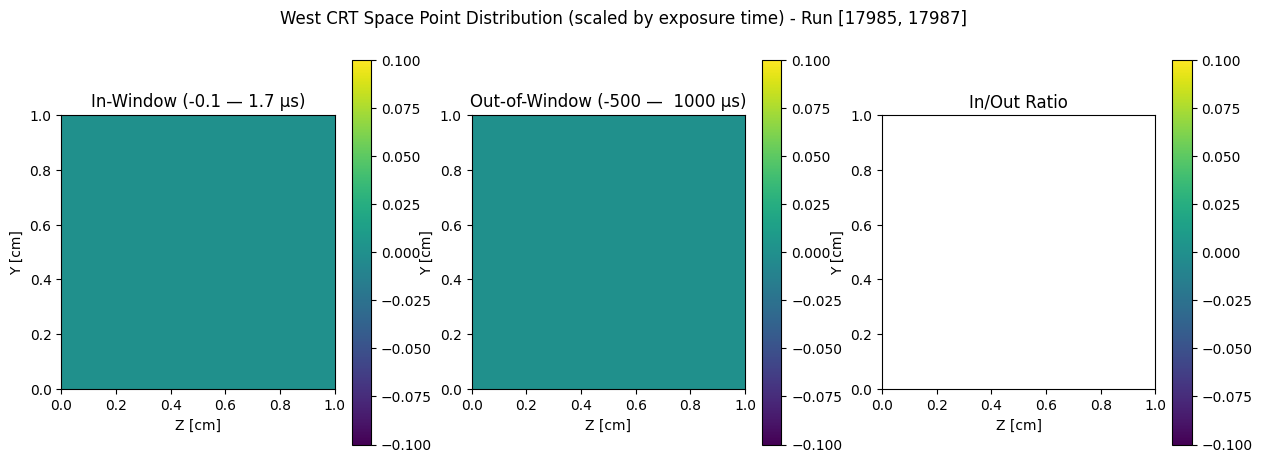

4
east/west


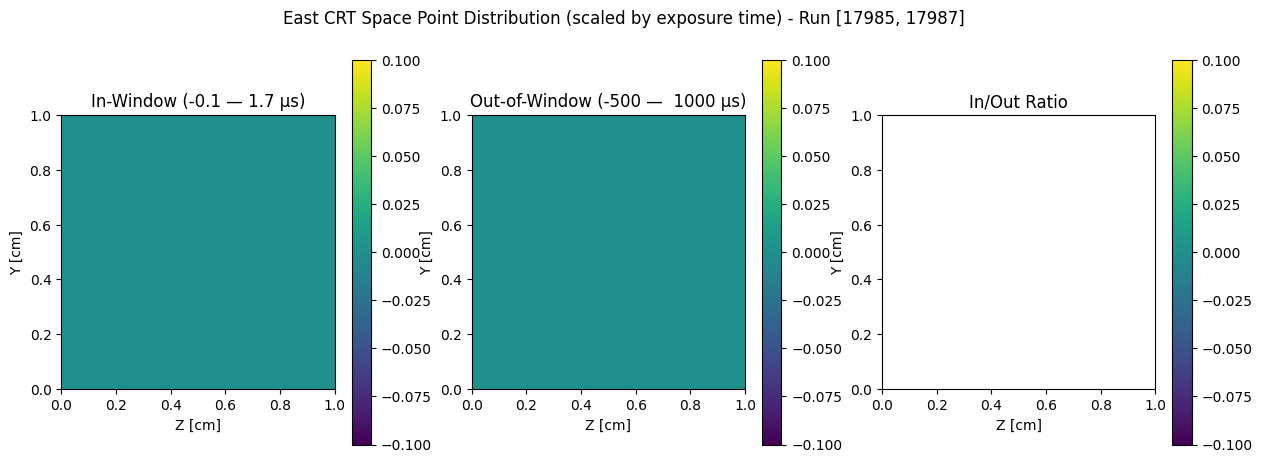

0
bottom/top


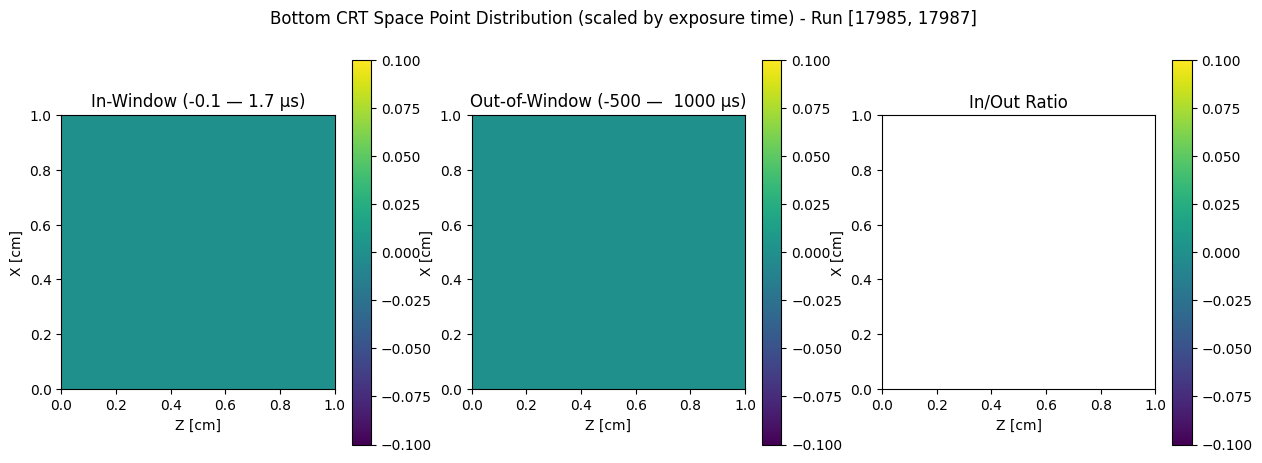

5
bottom/top


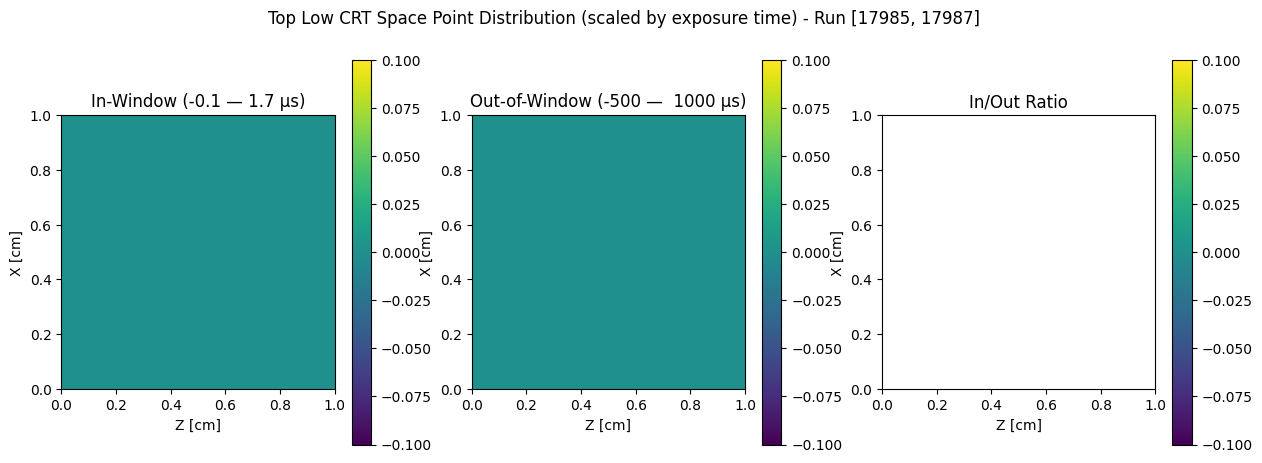

6
bottom/top


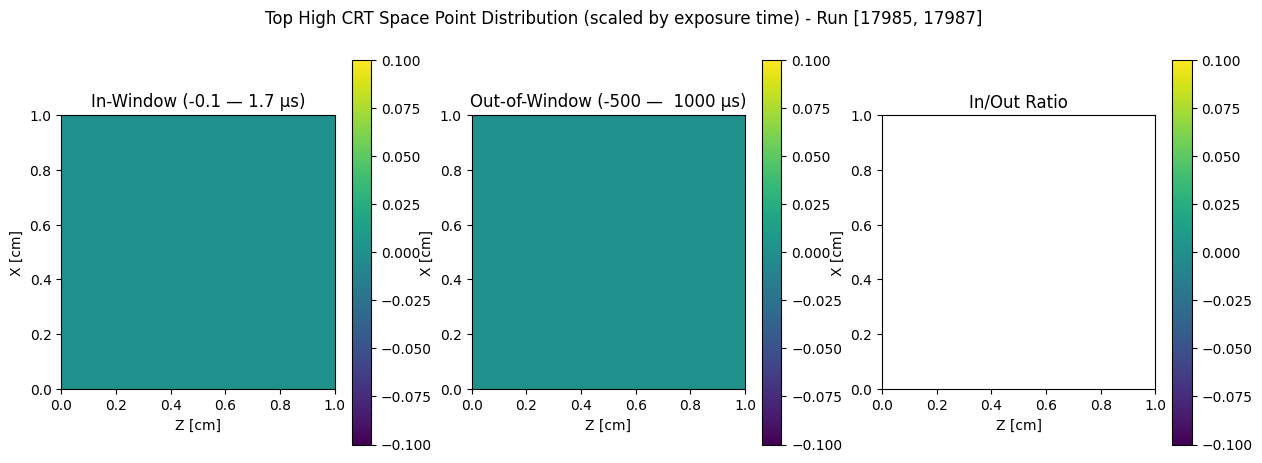

In [17]:
check_interval = False

for wall_id in (list(CRT_Wall_Dict.values())):
    print(wall_id)
    plot_sp_coord_ratio(ts0_rwm, spx, spy, spz, wall, list_of_runs, plot_wall=wall_id, interval_in=(-0.1, 1.7), interval_out=(-500, 1000), check_interval=check_interval, bins=10, save=True)